# Imports

In [1]:
!pip3 install torch torchvision torchaudio torchviz

In [2]:
import os
import pickle
import datetime
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import os
import json
import copy

import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose


from sklearn.metrics import confusion_matrix


Drive y Guardados

In [3]:
import google.colab
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/Redes_Neuronales"

os.makedirs(base_path, exist_ok=True)
os.makedirs(base_path + "/modelos", exist_ok=True)
os.makedirs(base_path + "/resultados", exist_ok=True)
os.makedirs(base_path + "/figuras", exist_ok=True)

guardar_modelos = base_path + "/modelos"
guardar_resultados = base_path + "/resultados"
guardar_figuras = base_path + "/figuras"

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Fashion_MNIST

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input  = image
        output = image #torch.flatten(image) # retornamos la imagen como salida
        return input,output


train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 186kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.53MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.2MB/s]


# Redes

## Autoncoder

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, n_bottleneck=128, p_dropout=0.2):
        super().__init__()

        #--------------encoder-------------------#
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = (3,3), padding = 1),                #Primera capa convolucional del encoder
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2)),

            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), padding = 1),               #Segunda capa convolucional del encoder
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2)),


            nn.Flatten(),
            nn.Linear(32*7*7, n_bottleneck),
            nn.Dropout(p = p_dropout)
        )

        #-------------Decoder-------------------#
        self.decoder = nn.Sequential(
            nn.Linear(n_bottleneck, 32*7*7),
            nn.Unflatten(1, (32, 7, 7)),
            # nn.Dropout(p = p_dropout),
            nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (2,2), stride = (2,2)),      #Primera capa convolucional en el decoder
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels = 16, out_channels = 1, kernel_size = (2,2), stride = (2,2)),       #Segunda capa convolucional en el decoder
            nn.Sigmoid()

            #al ser de 2 capas uso el kernel (2,2) Pues es el necesario para regresarme al tamaño original de 28*28
            #El tener 2 capas en lugar de 1 me permite tener mejores reconstrucciones y ser más estable
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [8]:
def entrenamiento(dataloader, model , loss_fn, optimizer):
  model.train()

  num_lotes = len(dataloader)
  num_samples = len(dataloader.dataset)
  sum_loss = 0
  count_samples = 0

  for batch, (X, y) in enumerate(dataloader):       #ojo al piojo con el y, en este caso es igual al x
    X, y = X.to(device), y.to(device)
    amplit_lotes = len(X)
    count_samples += amplit_lotes

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item() * amplit_lotes

    # if batch % (num_lotes/10) == 0: # This check can cause a ZeroDivisionError if num_lotes < 10.
    #   promedio_loss = sum_loss/count_samples
    #   print(f"@train_loop batch={batch:>5d} avrg_loss={promedio_loss:>7f}")

  assert count_samples == num_samples
  promedio_loss = sum_loss / count_samples
  return promedio_loss


def test(dataloader, model, loss_fn):
  model.eval()

  num_lotes = len(dataloader)
  num_samples = len(dataloader.dataset)
  sum_loss = 0
  count_samples = 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      amplit_lotes = len(X)
      count_samples += amplit_lotes
      pred = model(X)
      loss = loss_fn(pred, y)
      sum_loss += loss.item() * amplit_lotes
  assert count_samples == num_samples
  promedio_loss = sum_loss / count_samples
  return promedio_loss


## Clasificador

In [9]:
class Clasificador_Conv(nn.Module):
  def __init__(self, Autoencoder_conv, n_bottleneck=128, p_dropout=0.2):
    super().__init__()

    #Codificador
    self.encoder = copy.deepcopy(Autoencoder_conv.encoder)

    #Clasificador
    self.clasificador =  nn.Sequential(
        nn.BatchNorm1d(n_bottleneck),               #normalizamos los n_bottleneck para ganar presición
        nn.Linear(n_bottleneck,64),                 #primera capa
        nn.ReLU(),
        nn.Dropout(p_dropout),
        nn.Linear(64,10)                            #segunda capa
    )


  def forward(self, x):
    x = self.encoder(x)
    x = self.clasificador(x)
    return x

In [10]:
class Clasificador(nn.Module):
  def __init__(self, Autoencoder_fc, n_bottleneck=128, p_dropout=0.2):
    super().__init__()
    #Clasificador
    self.clasificador =  nn.Sequential(
        nn.BatchNorm(n_bottleneck),               #normalizamos los n_bottleneck para ganar presición
        nn.Linear(n_bottleneck,64),                 #primera capa
        nn.ReLU(),
        nn.Dropout(p_dropout),
        nn.Linear(64,10)                            #segunda capa
    )


  def forward(self, x):
    x = self.clasificador(x)
    return x




In [11]:

def entrenamiento_clasificador(dataloader, model , loss_fn, optimizer):
  model.train()

  num_lotes = len(dataloader)
  num_samples = len(dataloader.dataset)
  sum1 = 0
  sum2 = 0
  sum3 = 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    amplit_lotes = len(X)
    sum1 += amplit_lotes

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum2 += loss.item()*amplit_lotes
    sum3 += (pred.argmax(1) == y).type(torch.float).sum().item()

    if batch % (num_lotes/10) == 0:
      promedio_loss = sum2/sum1
      porcentaje_acierto = sum3/sum1
      #print(f"@train_loop batch={batch:>5d} avrg_loss={loss:>7f} avrg_prec={porcentaje_acierto:>5f}")
  assert sum1 == num_samples
  promedio_loss = sum2/sum1
  porcentaje_acierto = sum3/sum1
  return promedio_loss, porcentaje_acierto

def test_clasificador(dataloader, model, loss_fn):
  model.eval()

  num_lotes = len(dataloader)
  num_samples = len(dataloader.dataset)
  sum1 = 0
  sum2 = 0
  sum3 = 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      amplit_lotes = len(X)
      sum1 += amplit_lotes
      pred = model(X)
      loss = loss_fn(pred, y)
      sum2 += loss.item()*amplit_lotes
      sum3 += (pred.argmax(1) == y).type(torch.float).sum().item()
  assert sum1 == num_samples
  promedio_loss = sum2/sum1
  porcentaje_acierto = sum3/sum1
  return promedio_loss, porcentaje_acierto

# Parametros


In [12]:
p_dropout = 0.1
L_R = 0.001
epocas = 70
batch = 100


train_loader = DataLoader(train_set, batch_size=batch, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch, shuffle=False)

num_train_batchs = len(train_loader)
num_valid_batchs = len(valid_loader)

print(f"num_train_batchs = {num_train_batchs} \nnum_valid_batchs = {num_valid_batchs}")

Loss = nn.MSELoss()



# Re-initialize the model with the new p_dropout
model = Autoencoder(p_dropout=p_dropout).to(device)

# Re-initialize the optimizer with the new model parameters and learning rate
optimizer = optim.Adam(model.parameters(), L_R)

# Re-initialize the DataLoaders with the new batch size
train_loader = DataLoader(train_set, batch_size=batch, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch, shuffle=False)


list_promedio_loss_train_during_epoch = []
list_promedio_loss_train_after_epoch = []
list_promedio_loss_valid_after_epoch = []



num_train_batchs = 600 
num_valid_batchs = 100


In [13]:
import itertools

# 1. Definimos una paleta de colores "Científica" (Hex Codes)
# Estos colores son distinguibles incluso en blanco y negro o para daltónicos.
colores = [
    '#E69F00', # Naranja (Orange)
    '#56B4E9', # Celeste (Sky Blue)
    '#009E73', # Verde Azulado (Bluish Green)
    '#F0E442', # Amarillo (Yellow)
    '#0072B2', # Azul (Blue)
    '#D55E00', # Bermellón (Vermilion)
    '#CC79A7', # Púrpura Rojizo (Reddish Purple)
    '#000000'  # Negro (Black)
]

#Entrenamiento Encoder

#Handler Functions

In [14]:
"""
def entrenamiento_autoencoder(dataloader, model , loss_fn, optimizer):

  # These lists are re-initialized at the beginning of each function call
  list_promedio_loss_train_during_epoch = []
  list_promedio_loss_train_after_epoch = []
  list_promedio_loss_valid_after_epoch = []

  for i in range(epocas):
    print(f"Épocas {i+1}\n-------------------------------")

    # Training step (returns average loss calculated during the epoch)
    loss_train_during_epoch = entrenamiento(train_loader, model, Loss, optimizer)
    list_promedio_loss_train_during_epoch.append(loss_train_during_epoch)

    # Evaluation on training set after the epoch
    loss_train_after_epoch = test(train_loader, model, Loss)
    list_promedio_loss_train_after_epoch.append(loss_train_after_epoch)

    # Evaluation on validation set after the epoch
    loss_valid_after_epoch = test(valid_loader, model, Loss)
    list_promedio_loss_valid_after_epoch.append(loss_valid_after_epoch)

  return list_promedio_loss_train_during_epoch, list_promedio_loss_train_after_epoch, list_promedio_loss_valid_after_epoch
  """

'\ndef entrenamiento_autoencoder(dataloader, model , loss_fn, optimizer):\n\n  # These lists are re-initialized at the beginning of each function call\n  list_promedio_loss_train_during_epoch = []\n  list_promedio_loss_train_after_epoch = []\n  list_promedio_loss_valid_after_epoch = []\n\n  for i in range(epocas):\n    print(f"Épocas {i+1}\n-------------------------------")\n\n    # Training step (returns average loss calculated during the epoch)\n    loss_train_during_epoch = entrenamiento(train_loader, model, Loss, optimizer)\n    list_promedio_loss_train_during_epoch.append(loss_train_during_epoch)\n\n    # Evaluation on training set after the epoch\n    loss_train_after_epoch = test(train_loader, model, Loss)\n    list_promedio_loss_train_after_epoch.append(loss_train_after_epoch)\n\n    # Evaluation on validation set after the epoch\n    loss_valid_after_epoch = test(valid_loader, model, Loss)\n    list_promedio_loss_valid_after_epoch.append(loss_valid_after_epoch)\n\n  return lis

In [15]:
def entrenamiento_autoencoder(dataloader, model , loss_fn, optimizer, epocas, checkpoint_interval=5, checkpoint_dir=None):

  list_promedio_loss_train_during_epoch = []
  list_promedio_loss_train_after_epoch = []
  list_promedio_loss_valid_after_epoch = []
  start_epoch = 0

  # Check for existing checkpoint
  if checkpoint_dir:
    os.makedirs(checkpoint_dir, exist_ok=True)
    latest_checkpoint = None
    for f in os.listdir(checkpoint_dir):
        if f.startswith("checkpoint_epoch_") and f.endswith(".pth"):
            epoch_num = int(f.split('_')[2].split('.')[0])
            if latest_checkpoint is None or epoch_num > int(latest_checkpoint.split('_')[2].split('.')[0]):
                latest_checkpoint = f

    if latest_checkpoint:
      checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
      print(f"Loading checkpoint from {checkpoint_path}")
      checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu')) # Added map_location
      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      start_epoch = checkpoint['epoch'] + 1
      list_promedio_loss_train_during_epoch = checkpoint['loss_train_during_epoch_history']
      list_promedio_loss_train_after_epoch = checkpoint['loss_train_after_epoch_history']
      list_promedio_loss_valid_after_epoch = checkpoint['loss_valid_after_epoch_history']
      print(f"Resuming training from epoch {start_epoch}")

  for i in range(start_epoch, epocas):
    print(f"Épocas {i+1}/{epocas}\n-------------------------------")

    # Training step (returns average loss calculated during the epoch)
    loss_train_during_epoch = entrenamiento(train_loader, model, Loss, optimizer)
    list_promedio_loss_train_during_epoch.append(loss_train_during_epoch)

    # Evaluation on training set after the epoch
    loss_train_after_epoch = test(train_loader, model, Loss)
    list_promedio_loss_train_after_epoch.append(loss_train_after_epoch)

    # Evaluation on validation set after the epoch
    loss_valid_after_epoch = test(valid_loader, model, Loss)
    list_promedio_loss_valid_after_epoch.append(loss_valid_after_epoch)

    #print(f"  Train Loss (during): {loss_train_during_epoch:.4f}")
    #print(f"  Train Loss (after):  {loss_train_after_epoch:.4f}")
    #print(f"  Valid Loss (after):  {loss_valid_after_epoch:.4f}")

    # Save checkpoint periodically
    if checkpoint_dir and (i + 1) % checkpoint_interval == 0:
      checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{i+1}.pth")
      torch.save({
          'epoch': i,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss_train_during_epoch_history': list_promedio_loss_train_during_epoch,
          'loss_train_after_epoch_history': list_promedio_loss_train_after_epoch,
          'loss_valid_after_epoch_history': list_promedio_loss_valid_after_epoch,
      }, checkpoint_path)
      print(f"Checkpoint saved to {checkpoint_path}")

  return list_promedio_loss_train_during_epoch, list_promedio_loss_train_after_epoch, list_promedio_loss_valid_after_epoch



In [16]:
def entrenamiento_clasificador_con_checkpoint(train_dataloader, valid_dataloader, model, loss_fn, optimizer, epocas, checkpoint_interval=5, checkpoint_dir=None):

  list_incorrect_loss_history = []
  list_train_loss_history = []
  list_train_acc_history = []
  list_valid_loss_history = []
  list_valid_acc_history = []


  start_epoch = 0

  # Check for existing checkpoint
  if checkpoint_dir:
    os.makedirs(checkpoint_dir, exist_ok=True)
    latest_checkpoint = None
    latest_epoch_num = -1
    for f in os.listdir(checkpoint_dir):
        if f.startswith("checkpoint_epoch_") and f.endswith(".pth"):
            epoch_num = int(f.split('_')[2].split('.')[0])
            if epoch_num > latest_epoch_num:
                latest_epoch_num = epoch_num
                latest_checkpoint = f

    if latest_checkpoint:
      checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
      print(f"Loading checkpoint from {checkpoint_path}")
      checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      start_epoch = checkpoint['epoch'] + 1

      list_incorrect_loss_history = checkpoint['incorrect_loss_history']
      list_train_loss_history = checkpoint['train_loss_history']
      list_train_acc_history = checkpoint['train_acc_history']
      list_valid_loss_history = checkpoint['valid_loss_history']
      list_valid_acc_history = checkpoint['valid_acc_history']
      print(f"Resuming training from epoch {start_epoch}")

  for i in range(start_epoch, epocas):
    print(f"Épocas {i+1}/{epocas}\n-------------------------------")

    # Training step
    list_incorrect_loss_history.append(entrenamiento_clasificador(train_dataloader, model, loss_fn, optimizer))

    # Evaluation on training set
    train_loss, train_acc = test_clasificador(train_dataloader, model, loss_fn)
    list_train_loss_history.append(train_loss)
    list_train_acc_history.append(train_acc)

    # Evaluation on validation set
    valid_loss, valid_acc = test_clasificador(valid_dataloader, model, loss_fn)
    list_valid_loss_history.append(valid_loss)
    list_valid_acc_history.append(valid_acc)

    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"  Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.4f}")

    # Save checkpoint periodically
    if checkpoint_dir and (i + 1) % checkpoint_interval == 0:
      checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{i+1}.pth")
      torch.save({
          'epoch': i,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss_history': list_train_loss_history,
          'train_acc_history': list_train_acc_history,
          'valid_loss_history': list_valid_loss_history,
          'valid_acc_history': list_valid_acc_history,
          'incorrect_loss_history': list_incorrect_loss_history,
      }, checkpoint_path)
      print(f"Checkpoint saved to {checkpoint_path}")

  return list_train_loss_history, list_train_acc_history, list_valid_loss_history, list_valid_acc_history, list_incorrect_loss_history

In [17]:
def graficador_general(Resultados, nombre_parametro, titulo="Comparación de Modelos", save_to_folder=None, logx=False,logy=False):

    plt.rcParams.update({
        'font.size': 16,
        'lines.linewidth': 3
    })
    fig = plt.figure(figsize=(10, 6), dpi=150)


    # Mapa de colores dinámico
    n_curvas = len(Resultados)
    colors = cm.viridis(np.linspace(0, 0.9, n_curvas))

    for i, (valor_param, metricas) in enumerate(Resultados.items()):
        c = colors[i]
        epochs_range = range(1, len(metricas["loss_train"]) + 1)
        label_str = f"{valor_param}"

        # Ploteo de curvas
        plt.plot(epochs_range, metricas["loss_train"], linestyle='-', color=c, alpha=0.9, label=label_str)

        if "loss_valid" in metricas and len(metricas["loss_valid"]) > 0:
            plt.plot(epochs_range, metricas["loss_valid"], linestyle='--', color=c, alpha=0.8)

        #if "loss_incorrect" in metricas and len(metricas["loss_incorrect"]) > 0:
        #    plt.plot(epochs_range, metricas["loss_incorrect"], linestyle=':', color=c, linewidth=1.5, alpha=0.6)

    plt.xlabel("Épocas")
    plt.ylabel("Pérdida (Loss)")
    plt.title(titulo)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Doble leyenda para claridad
    first_legend = plt.legend(loc='upper right', title=nombre_parametro)
    plt.gca().add_artist(first_legend)

    linea_train = plt.Line2D([], [], color='black', linestyle='-', label='Train')
    linea_valid = plt.Line2D([], [], color='black', linestyle='--', label='Valid')
    #linea_incorr = plt.Line2D([], [], color='black', linestyle=':', label='Incorrect') # Descomentar si usas incorrect

    #plt.legend(handles=[linea_train, linea_valid], loc='center right', title="Dataset")
    plt.tight_layout()

    if save_to_folder:
        # Construct filename_prefix from title or nombre_parametro for saving
        filename_prefix = f"grafico_{nombre_parametro.replace(' ', '_').lower()}"
        if titulo and titulo != "Comparación de Modelos": # If title is more descriptive and not default
             filename_prefix = titulo.replace(' ', '_').lower()

        guardar_figura(fig, filename_prefix, subfolder=save_to_folder)
    current_figure = plt.gcf()

    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')


    plt.show()
    return current_figure




def graficar_ropa(model):
  model.eval()

  # Get a batch of test images
  dataiter = iter(valid_loader)
  images, labels = next(dataiter)

  # Move images to the device
  images = images.to(device)

  # Get sample outputs
  output = model(images)

  # Plot the first X images and their reconstructions
  num_images_to_show = 5
  images = images.cpu().numpy()
  output = output.cpu().detach().numpy()

  plt.figure(figsize=(10, 4))
  for i in range(num_images_to_show):
      # Original Image
      plt.subplot(2, num_images_to_show, i + 1)
      plt.imshow(images[i].squeeze(), cmap='gray')
      plt.title("Original")
      plt.axis('off')

      # Reconstructed Image
      plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
      plt.imshow(output[i].squeeze(), cmap='gray')
      plt.title("Reconstruida")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

In [18]:
def guardar_resultados_entrenamiento(resultados, filename_prefix, subfolder=None, hyperparameters=None,
                                     p_dropout_val=None, L_R_val=None, batch_val=None, optimizer_name=None, epocas_val=None):
    """
    Guarda un diccionario de resultados de entrenamiento en Google Drive.
    Crea una carpeta si no existe y añade un timestamp al nombre del archivo.
    Si se especifica `subfolder`, los resultados se guardan dentro de esa subcarpeta.
    Si se proporcionan `hyperparameters` o los parámetros individuales, también se guardarán en un archivo 'parametros.dat'.
    """
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    full_filename = f"{filename_prefix}_{timestamp}.pkl"

    if subfolder:
        base_save_dir = os.path.join(guardar_resultados, subfolder)
    else:
        base_save_dir = guardar_resultados

    os.makedirs(base_save_dir, exist_ok=True)

    save_path = os.path.join(base_save_dir, full_filename)

    with open(save_path, 'wb') as f:
        pickle.dump(resultados, f)
    print(f"Resultados de entrenamiento guardados en: {save_path}")

    # Prepare hyperparameters for saving
    params_to_save = hyperparameters if hyperparameters is not None else {}

    if p_dropout_val is not None:
        params_to_save['p_dropout'] = p_dropout_val
    if L_R_val is not None:
        params_to_save['L_R'] = L_R_val
    if batch_val is not None:
        params_to_save['batch'] = batch_val
    if optimizer_name is not None:
        params_to_save['optimizer'] = optimizer_name
    if epocas_val is not None:
        params_to_save['epocas'] = epocas_val

    if params_to_save and subfolder: # Only save if there are params and a subfolder is specified
        params_filename = "parametros.dat"
        params_save_path = os.path.join(base_save_dir, params_filename)
        with open(params_save_path, 'w') as f:
            # Save hyperparameters in a readable format (e.g., JSON)
            json.dump(params_to_save, f, indent=4)
        print(f"Hiperparámetros guardados en: {params_save_path}")

def guardar_figura(fig, filename_prefix, subfolder=None):
    """
    Guarda una figura de matplotlib en Google Drive.
    Crea una carpeta si no existe y añade un timestamp al nombre del archivo.
    Si se especifica `subfolder`, la figura se guarda dentro de esa subcarpeta.
    """
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    full_filename = f"{filename_prefix}_{timestamp}.png" # Puedes cambiar a .svg, .pdf, etc.

    if subfolder:
        base_save_dir = os.path.join(guardar_figuras, subfolder)
    else:
        base_save_dir = guardar_figuras

    os.makedirs(base_save_dir, exist_ok=True)

    save_path = os.path.join(base_save_dir, full_filename)

    fig.savefig(save_path, bbox_inches='tight')
    print(f"Figura guardada en: {save_path}")

In [19]:

def calcular_matriz_confusion(dataloader, model, device):
    y_true_list, y_pred_list = [], [] # Renamed to avoid confusion with numpy arrays

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            outputs = model(X)
            _, predicted = torch.max(outputs, 1)

            y_true_list.extend(y.cpu().numpy())
            y_pred_list.extend(predicted.cpu().numpy())

    # Explicitly convert to numpy arrays of integers to ensure consistent types
    y_true_np = np.array(y_true_list).astype(int)
    y_pred_np = np.array(y_pred_list).astype(int)

    # Calculate confusion matrix with normalization by true labels
    return confusion_matrix(y_true_np, y_pred_np, normalize='true')



# Programa Autoencoder


In [20]:
p_dropout                       = 0.2
L_R                             = 0.001
autoencoder_epocas              = 20 # Increased epochs for autoencoder pre-training
epocas                          = 20 # Classifier training epochs
batch                           = 1000
checkpoint_interval             = 5

train_loader = DataLoader(train_set, batch_size=batch, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch, shuffle=False)

num_train_batchs              = len(train_loader)
num_valid_batchs = len(valid_loader)

print(f"num_train_batchs = {num_train_batchs} \nnum_valid_batchs = {num_valid_batchs}")

Loss = nn.MSELoss()

# Re-initialize the model with the new p_dropout
model = Autoencoder(p_dropout=p_dropout).to(device)

# Re-initialize the optimizer with the new model parameters and learning rate
optimizer = optim.Adam(model.parameters(), L_R)

# Re-initialize the DataLoaders with the new batch size
train_loader = DataLoader(train_set, batch_size=batch, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch, shuffle=False)


list_promedio_loss_train_during_epoch = []
list_promedio_loss_train_after_epoch  = []
list_promedio_loss_valid_after_epoch  = []

num_train_batchs = 60 
num_valid_batchs = 10


## no variacion de parametros

In [21]:
train_loader_clf = DataLoader(train_set_orig, batch_size=batch, shuffle=True)
valid_loader_clf = DataLoader(valid_set_orig, batch_size=batch, shuffle=False)
# Ensure autoencoder uses the updated autoencoder_epocas
epocas_autoencoder_training = 20 # Use the specific epochs for autoencoder pre-training

checkpoint_dir = os.path.join(base_path, "checkpoints", f"no_variacion")

loss_incorrect, loss_train, loss_valid = entrenamiento_autoencoder(train_loader, model, Loss, optimizer, epocas_autoencoder_training, checkpoint_interval, checkpoint_dir)

Resultados_autoencoder_base={}
Resultados_autoencoder_base["no_variacion"] = {
    "loss_train": loss_train,
    "loss_valid": loss_valid,
    "loss_incorrect": loss_incorrect}
Resultados = {
    "loss_train": loss_train,
    "loss_valid": loss_valid,
    "loss_incorrect": loss_incorrect}
# Save the results of the base autoencoder training
guardar_resultados_entrenamiento(Resultados_autoencoder_base, "no_variacion_base_autoencoder", "Base_Autoencoder_Training")


Loading checkpoint from /content/drive/MyDrive/Redes_Neuronales/checkpoints/no_variacion/checkpoint_epoch_20.pth
Resuming training from epoch 20
Resultados de entrenamiento guardados en: /content/drive/MyDrive/Redes_Neuronales/resultados/Base_Autoencoder_Training/no_variacion_base_autoencoder_20251230_144210.pkl


In [22]:
guardar_resultados_entrenamiento(Resultados,"no_variacion","Sin_variar")

Resultados de entrenamiento guardados en: /content/drive/MyDrive/Redes_Neuronales/resultados/Sin_variar/no_variacion_20251230_144211.pkl


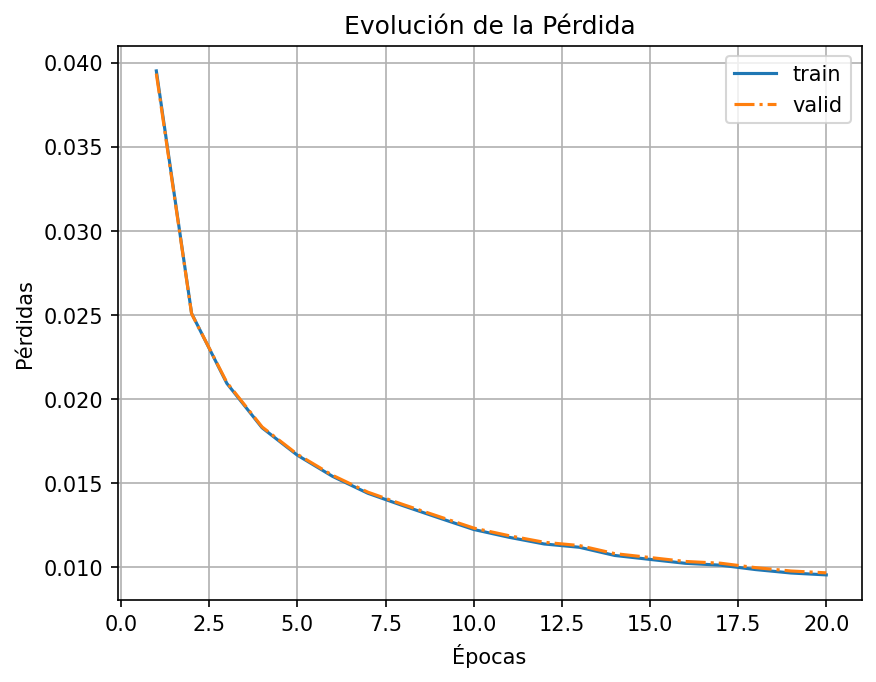

Figura guardada en: /content/drive/MyDrive/Redes_Neuronales/figuras/Sin variar/Sin variar_20251230_144211.png


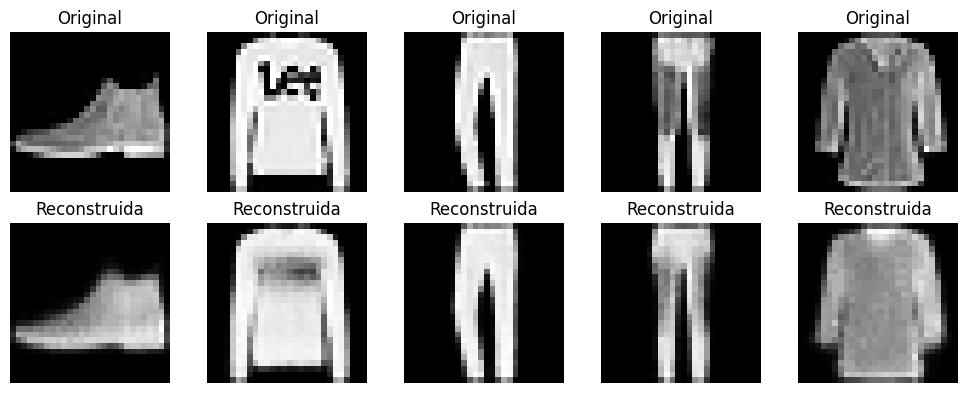

In [23]:
epochs_range = range(1, len(loss_train) + 1)

plt.figure(dpi=150)


plt.xlabel("Épocas")
plt.ylabel("Pérdidas")
plt.title("Evolución de la Pérdida")
plt.xlim(-0.1,len(loss_incorrect)+1)
#plt.plot(epochs_range, loss_incorrect, label="train incorrect",linestyle='--')
plt.plot(epochs_range, loss_train, label="train",linestyle='-')
plt.plot(epochs_range, loss_valid, label="valid",linestyle='-.')
plt.grid()
plt.legend()
current_figure = plt.gcf() # Moved this line to capture the figure before showing/clearing
plt.show()

guardar_figura(current_figure, "Sin variar", "Sin variar")

graficar_ropa(model)

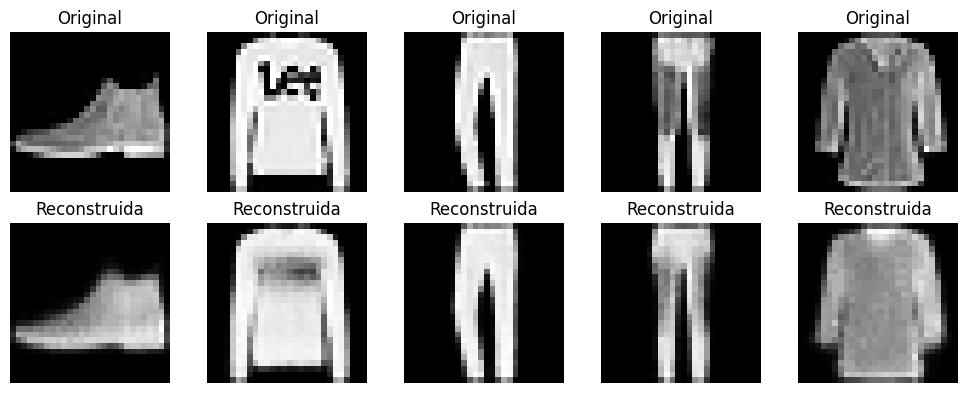

In [24]:
graficar_ropa(model)

In [25]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"autoencoder_no_variacion_{timestamp}.pth"
model_save_path = os.path.join(guardar_modelos, model_filename)

torch.save(model.state_dict(), model_save_path)
print(f"Modelo Autoencoder guardado en: {model_save_path}")

guardar_resultados_entrenamiento(Resultados,"no_variacion","Sin_variar")

Modelo Autoencoder guardado en: /content/drive/MyDrive/Redes_Neuronales/modelos/autoencoder_no_variacion_20251230_144214.pth
Resultados de entrenamiento guardados en: /content/drive/MyDrive/Redes_Neuronales/resultados/Sin_variar/no_variacion_20251230_144214.pkl


## Variacion Dropout

In [26]:
p_dropouts = [0.0, 0.1, 0.2]
Resultados = {}
epocas = 20
for p_dropout in p_dropouts:
  print(f"Entrenando para p_dropout = {p_dropout}\n-------------------------------")

  # Re-initialize the model
  model = Autoencoder(p_dropout = p_dropout).to(device)
  optimizer = optim.Adam(model.parameters(), L_R)


  checkpoint_dir_dropout = os.path.join(base_path, "checkpoints", f"Dropout_{p_dropout}_probamosconp0")
  # Call entrenamiento_autoencoder and capture the returned history lists
  loss_train_incorrect_history_p, loss_train_history_p, loss_valid_history_p = entrenamiento_autoencoder(train_loader, model, Loss, optimizer, epocas, checkpoint_interval, checkpoint_dir_dropout)

  Resultados[p_dropout] = {
      "loss_incorrect": loss_train_incorrect_history_p,
      "loss_train": loss_train_history_p,
      "loss_valid": loss_valid_history_p
  }

Entrenando para p_dropout = 0.0
-------------------------------
Épocas 1/20
-------------------------------
Épocas 2/20
-------------------------------
Épocas 3/20
-------------------------------
Épocas 4/20
-------------------------------
Épocas 5/20
-------------------------------
Checkpoint saved to /content/drive/MyDrive/Redes_Neuronales/checkpoints/Dropout_0.0_probamosconp0/checkpoint_epoch_5.pth
Épocas 6/20
-------------------------------
Épocas 7/20
-------------------------------
Épocas 8/20
-------------------------------
Épocas 9/20
-------------------------------
Épocas 10/20
-------------------------------
Checkpoint saved to /content/drive/MyDrive/Redes_Neuronales/checkpoints/Dropout_0.0_probamosconp0/checkpoint_epoch_10.pth
Épocas 11/20
-------------------------------
Épocas 12/20
-------------------------------
Épocas 13/20
-------------------------------
Épocas 14/20
-------------------------------
Épocas 15/20
-------------------------------
Checkpoint saved to /conten

In [27]:
guardar_resultados_entrenamiento(Resultados,"Dropout","Dropout")

Resultados de entrenamiento guardados en: /content/drive/MyDrive/Redes_Neuronales/resultados/Dropout/Dropout_20251230_145702.pkl


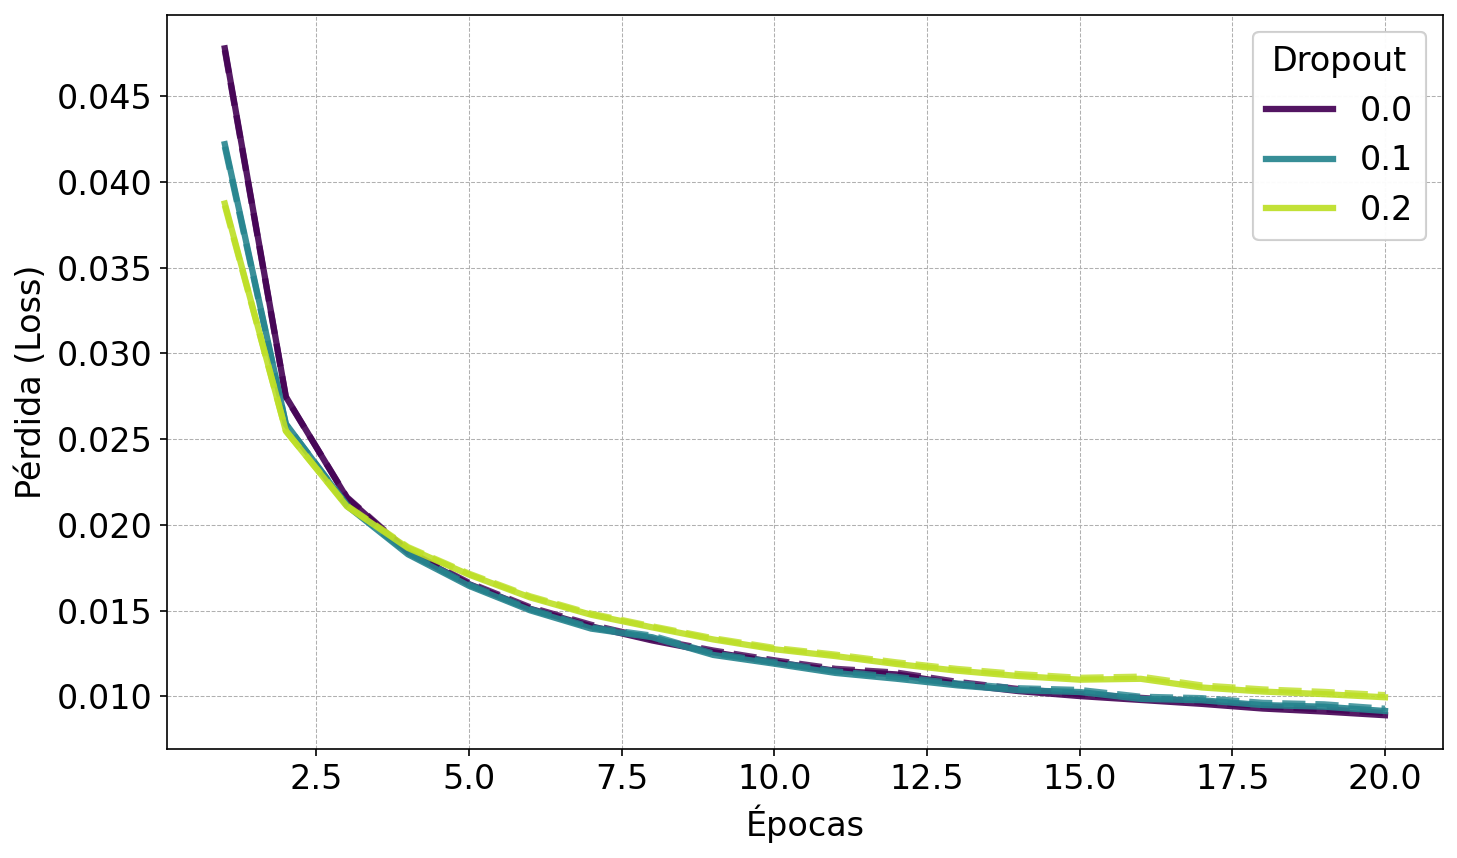

Figura guardada en: /content/drive/MyDrive/Redes_Neuronales/figuras/Dropout/Dropout_20251230_145703.png


In [28]:
current_figure = graficador_general(Resultados, "Dropout", titulo="")

guardar_figura(current_figure, "Dropout", "Dropout")

## Variacion  Learning rate

In [29]:
p_dropout = 0.2
Resultados = {}
Learning_rates=[0.0001, 0.001, 0.01]
model = Autoencoder(p_dropout = p_dropout).to(device)


for L_R in Learning_rates:
  print(f"Entrenando para Learning Rate = {L_R}\n-------------------------------")

  # Re-initialize the model
  optimizer = optim.Adam(model.parameters(), L_R)

  checkpoint_dir = os.path.join(base_path, "checkpoints", f"LearningRate_{L_R}")
  # Call entrenamiento_autoencoder and capture the returned history lists
  loss_train_incorrect_history_p, loss_train_history_p, loss_valid_history_p = entrenamiento_autoencoder(train_loader, model, Loss, optimizer, epocas, checkpoint_interval, checkpoint_dir)

  Resultados[L_R] = {
      "loss_incorrect": loss_train_incorrect_history_p,
      "loss_train": loss_train_history_p,
      "loss_valid": loss_valid_history_p
  }

Entrenando para Learning Rate = 0.0001
-------------------------------
Loading checkpoint from /content/drive/MyDrive/Redes_Neuronales/checkpoints/LearningRate_0.0001/checkpoint_epoch_70.pth
Resuming training from epoch 70
Entrenando para Learning Rate = 0.001
-------------------------------
Loading checkpoint from /content/drive/MyDrive/Redes_Neuronales/checkpoints/LearningRate_0.001/checkpoint_epoch_70.pth
Resuming training from epoch 70
Entrenando para Learning Rate = 0.01
-------------------------------
Loading checkpoint from /content/drive/MyDrive/Redes_Neuronales/checkpoints/LearningRate_0.01/checkpoint_epoch_70.pth
Resuming training from epoch 70


In [30]:
guardar_resultados_entrenamiento(Resultados,"L_R","Learning_Rate")

Resultados de entrenamiento guardados en: /content/drive/MyDrive/Redes_Neuronales/resultados/Learning_Rate/L_R_20251230_145709.pkl


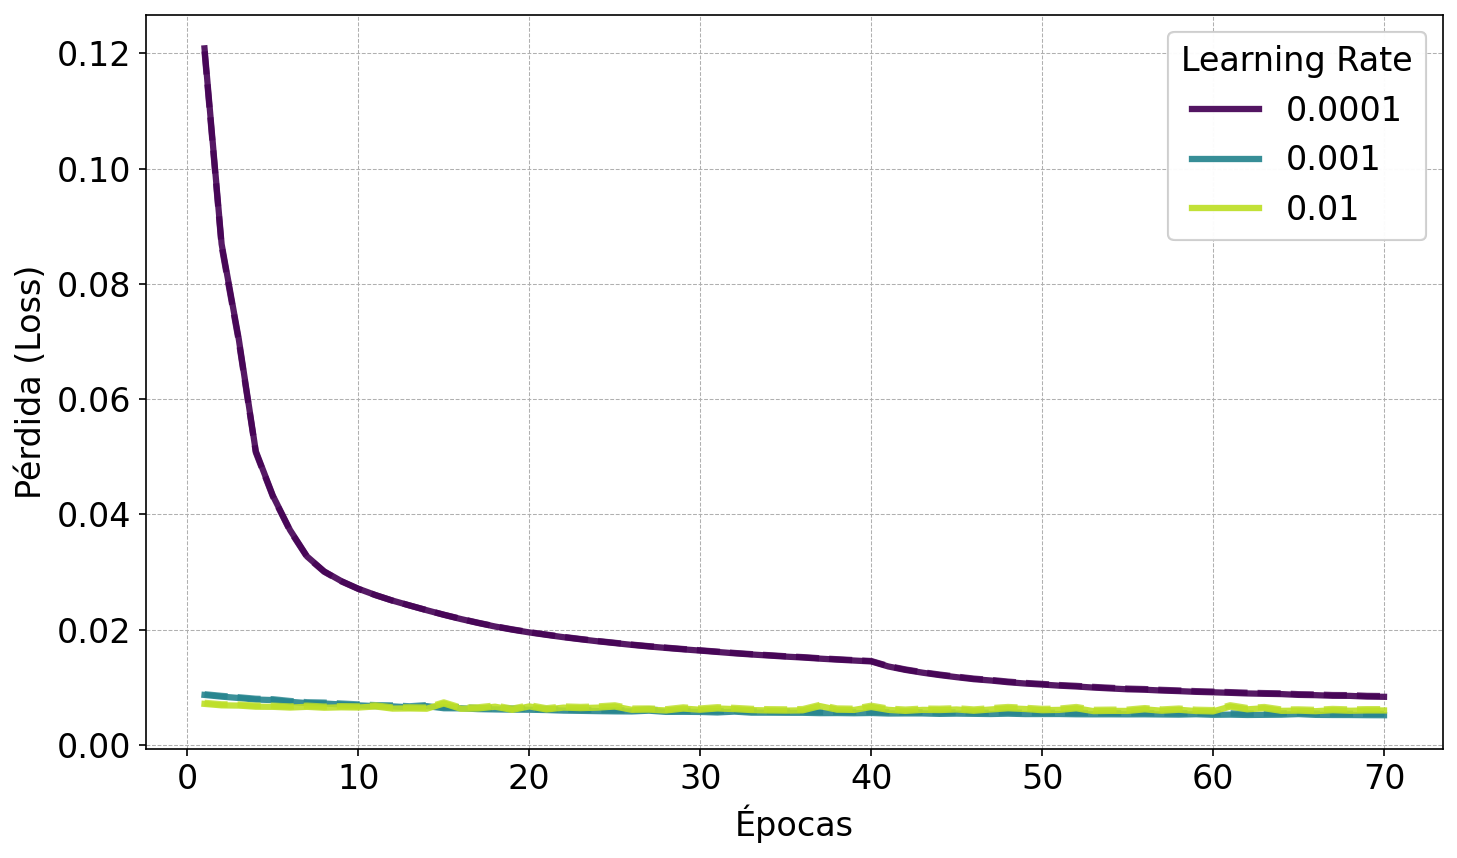

Figura guardada en: /content/drive/MyDrive/Redes_Neuronales/figuras/log/grafico_learning_rate_20251230_145710.png


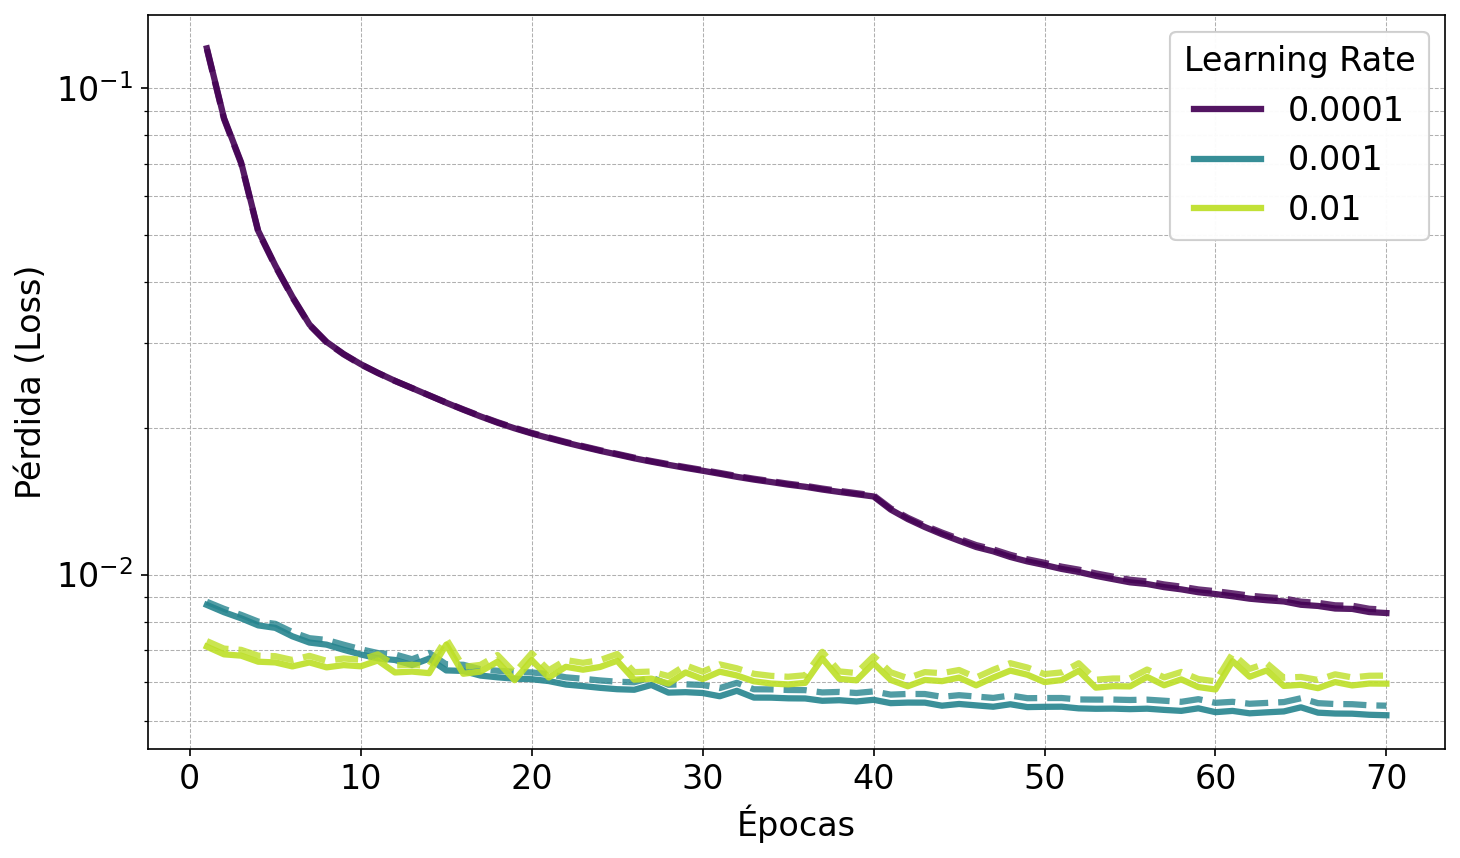

Figura guardada en: /content/drive/MyDrive/Redes_Neuronales/figuras/Learning_Rate/L_R_20251230_145710.png


In [31]:

current_figure = graficador_general(Resultados, "Learning Rate", titulo="")

graficador_general(Resultados, "Learning Rate", titulo="", save_to_folder='log', logx=False,logy=True)

guardar_figura(current_figure, "L_R", "Learning_Rate")

## Variacion Batches

In [32]:
p_dropout                       = 0.2
Resultados                      = {}
L_R                             = 0.001
model = Autoencoder(p_dropout   = p_dropout).to(device)
batches                         = [10,100,500]

for batch in batches:
  print(f"Entrenando para Batches = {batch}\n-------------------------------")

  # Re-initialize the model
  optimizer         = optim.Adam(model.parameters(), L_R)

  checkpoint_dir    = os.path.join(base_path, "checkpoints", f"Batches_{batch}")
  # Call entrenamiento_autoencoder and capture the returned history lists
  loss_train_incorrect_history_p, loss_train_history_p, loss_valid_history_p = entrenamiento_autoencoder(train_loader, model, Loss, optimizer, epocas, checkpoint_interval, checkpoint_dir)

  Resultados[batch] = {
      "loss_incorrect": loss_train_incorrect_history_p,
      "loss_train"    : loss_train_history_p,
      "loss_valid"    : loss_valid_history_p
  }

Entrenando para Batches = 10
-------------------------------
Loading checkpoint from /content/drive/MyDrive/Redes_Neuronales/checkpoints/Batches_10/checkpoint_epoch_70.pth
Resuming training from epoch 70
Entrenando para Batches = 100
-------------------------------
Loading checkpoint from /content/drive/MyDrive/Redes_Neuronales/checkpoints/Batches_100/checkpoint_epoch_70.pth
Resuming training from epoch 70
Entrenando para Batches = 500
-------------------------------
Loading checkpoint from /content/drive/MyDrive/Redes_Neuronales/checkpoints/Batches_500/checkpoint_epoch_70.pth
Resuming training from epoch 70


In [33]:
guardar_resultados_entrenamiento(Resultados,"batches","Batches_autoencoder")

Resultados de entrenamiento guardados en: /content/drive/MyDrive/Redes_Neuronales/resultados/Batches_autoencoder/batches_20251230_145718.pkl


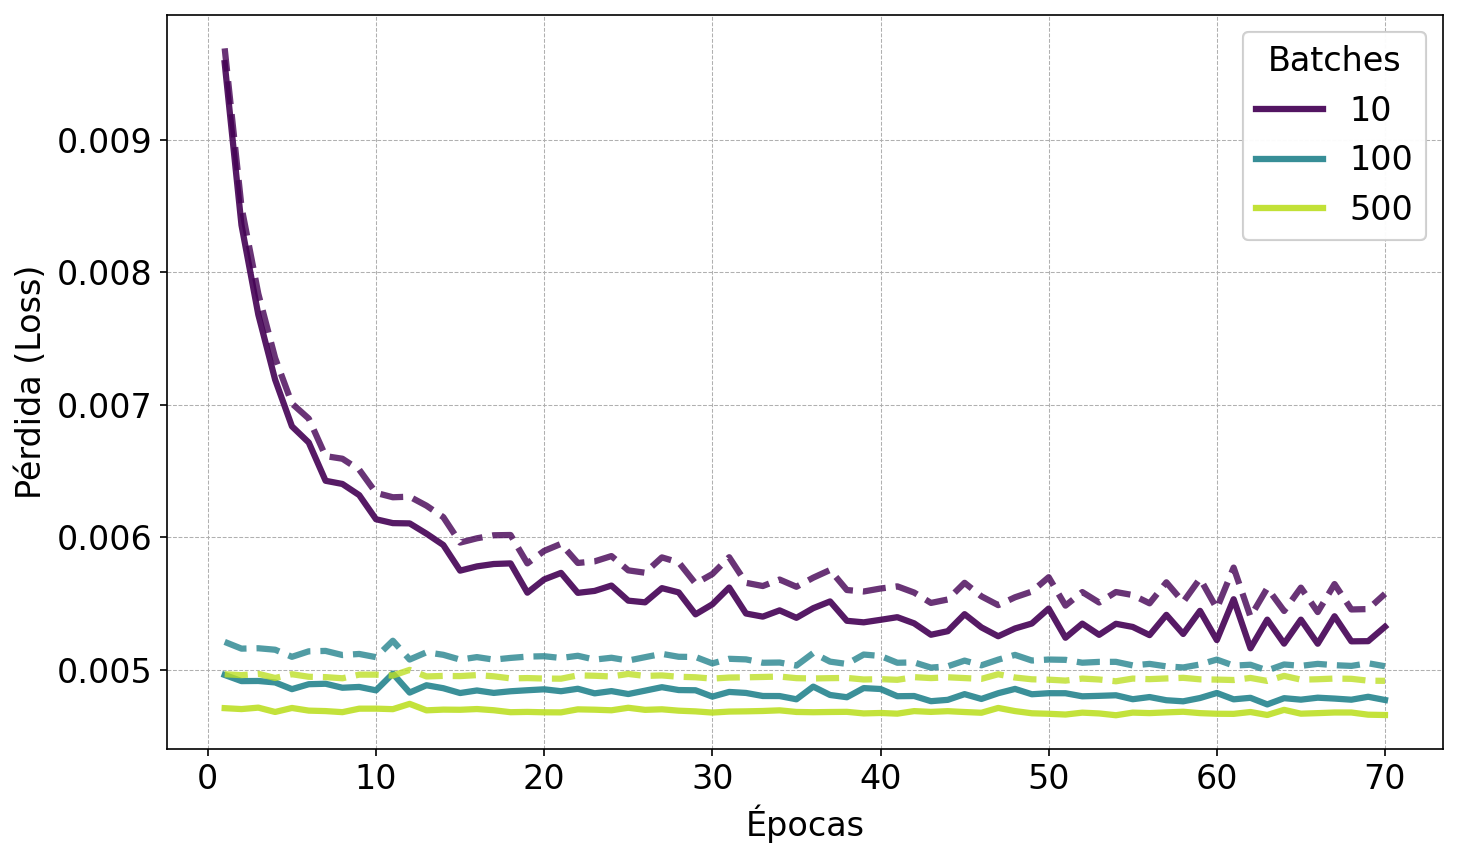

Figura guardada en: /content/drive/MyDrive/Redes_Neuronales/figuras/Batches/Batches_20251230_145718.png


In [34]:
current_figure = graficador_general(Resultados, "Batches", titulo="")

guardar_figura(current_figure, "Batches", "Batches")

# Clasificador Pre entrenado

In [35]:
p_dropout                       = 0.2
L_R                             = 0.001
batch                           = 1000
epocas                          = 20 # Classifier training epochs
checkpoint_interval             = 5
autoencoder_epocas              = 20 # Use this to load correct autoencoder checkpoint

# Initialize the Autoencoder (will be loaded with pre-trained weights)
autoencoder_model = Autoencoder(p_dropout=p_dropout).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_dir = "/content/drive/MyDrive/Redes_Neuronales/checkpoints/no_variacion"

# Define DataLoaders for classification
train_loader_clasificador = DataLoader(train_set_orig, batch_size=batch, shuffle=True)
valid_loader_clasificador = DataLoader(valid_set_orig, batch_size=batch, shuffle=False)

# Load the full checkpoint dictionary from the autoencoder training
# Load the checkpoint corresponding to the full autoencoder_epocas training
checkpoint = torch.load(os.path.join(checkpoint_dir, f"checkpoint_epoch_{autoencoder_epocas}.pth"), map_location=torch.device(device))

# Load only the model's state_dict from the checkpoint into the autoencoder_model
autoencoder_model.load_state_dict(checkpoint['model_state_dict'])

# Create the classifier model using the autoencoder's encoder
model_clasificador = Clasificador_Conv(autoencoder_model, n_bottleneck=128, p_dropout=p_dropout).to(device)

# Define loss function for classification (CrossEntropyLoss is appropriate for multi-class classification)
Loss_clasificador = nn.CrossEntropyLoss()

# Optimizer for the classifier model
optimizer_clasificador = optim.Adam(model_clasificador.parameters(), L_R)


checkpoint_dir_clasificador = os.path.join(base_path, "checkpoints", "Clasificador_PreEntrenado")

for param in model_clasificador.encoder.parameters():
    param.requires_grad = True # Here, the encoder is unfrozen for fine-tuning



# Call the classifier training function with checkpointing
list_train_loss, list_train_acc, list_valid_loss, list_valid_acc, list_incorrect_loss_history = entrenamiento_clasificador_con_checkpoint(train_loader_clasificador, valid_loader_clasificador, model_clasificador, Loss_clasificador, optimizer_clasificador, epocas, checkpoint_interval, checkpoint_dir_clasificador)

cm_valid_1 = calcular_matriz_confusion(valid_loader_clasificador, model_clasificador, device)

Resultados[1] = {
    "train_loss": list_train_loss,
    "train_acc": list_train_acc,
    "valid_loss": list_valid_loss,
    "valid_acc": list_valid_acc
}

Loading checkpoint from /content/drive/MyDrive/Redes_Neuronales/checkpoints/Clasificador_PreEntrenado/checkpoint_epoch_20.pth
Resuming training from epoch 20


## clasificador y encoder desde 0

In [36]:


#Initializing encoder
autoencoder_model = Autoencoder(p_dropout=p_dropout).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the full checkpoint dictionary
#checkpoint = torch.load('/content/drive/MyDrive/Redes_Neuronales/checkpoints/no_variacion/checkpoint_70.pth', map_location=torch.device(device))

# Load only the model's state_dict from the checkpoint
#autoencoder_model.load_state_dict(checkpoint['model_state_dict'])

# Create the classifier model using the autoencoder's encoder
model_clasificador = Clasificador_Conv(autoencoder_model, n_bottleneck=128, p_dropout=p_dropout).to(device)

# Define loss function for classification (CrossEntropyLoss is appropriate for multi-class classification)
Loss_clasificador = nn.CrossEntropyLoss()

# Optimizer for the classifier model
optimizer_clasificador = optim.Adam(model_clasificador.parameters(), L_R)

# DataLoaders for classification using the original FashionMNIST datasets (yielding image, label pairs)
train_loader_clasificador = DataLoader(train_set_orig, batch_size=batch, shuffle=True)
valid_loader_clasificador = DataLoader(valid_set_orig, batch_size=batch, shuffle=False)

checkpoint_dir_clasificador = os.path.join(base_path, "checkpoints", "Clasificador_sin_PreEntrenado")

for param in model_clasificador.encoder.parameters():
    param.requires_grad = True


# Call the classifier training function with checkpointing
list_train_loss, list_train_acc, list_valid_loss, list_valid_acc, list_incorrect_loss_history = entrenamiento_clasificador_con_checkpoint(train_loader_clasificador, valid_loader_clasificador, model_clasificador, Loss_clasificador, optimizer_clasificador, epocas, checkpoint_interval, checkpoint_dir_clasificador)


Resultados[2] = {
    "train_loss": list_train_loss,
    "train_acc": list_train_acc,
    "valid_loss": list_valid_loss,
    "valid_acc": list_valid_acc
}

Loading checkpoint from /content/drive/MyDrive/Redes_Neuronales/checkpoints/Clasificador_sin_PreEntrenado/checkpoint_epoch_20.pth
Resuming training from epoch 20


## solo entrenar clasificador, encoder congelado

In [37]:

# Initialize the Autoencoder
autoencoder_model = Autoencoder(p_dropout=p_dropout).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_dir = "/content/drive/MyDrive/Redes_Neuronales/checkpoints/no_variacion"

# Define DataLoaders for classification (already present, just move down if needed)
train_loader_clasificador = DataLoader(train_set_orig, batch_size=batch, shuffle=True)
valid_loader_clasificador = DataLoader(valid_set_orig, batch_size=batch, shuffle=False)

# Load the full checkpoint dictionary from the autoencoder training
# Load the checkpoint corresponding to the full autoencoder_epocas training
checkpoint = torch.load(os.path.join(checkpoint_dir, f"checkpoint_epoch_{autoencoder_epocas}.pth"), map_location=torch.device(device))

# Load only the model's state_dict from the checkpoint into the autoencoder_model
autoencoder_model.load_state_dict(checkpoint['model_state_dict'])

# Create the classifier model using the autoencoder's encoder
model_clasificador = Clasificador_Conv(autoencoder_model, n_bottleneck=128, p_dropout=p_dropout).to(device)

# Define loss function for classification (CrossEntropyLoss is appropriate for multi-class classification)
Loss_clasificador = nn.CrossEntropyLoss()

# Optimizer for the classifier model
optimizer_clasificador = optim.Adam(model_clasificador.parameters(), L_R)


checkpoint_dir_clasificador = os.path.join(base_path, "checkpoints", "Clasificador_congelado")

for param in model_clasificador.encoder.parameters():
    param.requires_grad = False # Here, the encoder is frozen for fine-tuning



# Call the classifier training function with checkpointing
list_train_loss, list_train_acc, list_valid_loss, list_valid_acc, list_incorrect_loss_history = entrenamiento_clasificador_con_checkpoint(train_loader_clasificador, valid_loader_clasificador, model_clasificador, Loss_clasificador, optimizer_clasificador, epocas, checkpoint_interval, checkpoint_dir_clasificador)


Resultados[3] = {
    "train_loss": list_train_loss,
    "train_acc": list_train_acc,
    "valid_loss": list_valid_loss,
    "valid_acc": list_valid_acc
}

Loading checkpoint from /content/drive/MyDrive/Redes_Neuronales/checkpoints/Clasificador_congelado/checkpoint_epoch_20.pth
Resuming training from epoch 20


## solo entrenador clasificador, encoder no pre entrenado congleado

In [38]:

# Initialize the Autoencoder
autoencoder_model = Autoencoder(p_dropout=p_dropout).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_dir = "/content/drive/MyDrive/Redes_Neuronales/checkpoints/no_variacion"

# Define DataLoaders for classification (already present, just move down if needed)
train_loader_clasificador = DataLoader(train_set_orig, batch_size=batch, shuffle=True)
valid_loader_clasificador = DataLoader(valid_set_orig, batch_size=batch, shuffle=False)

# Load the full checkpoint dictionary from the autoencoder training
# Load the checkpoint corresponding to the full autoencoder_epocas training
#checkpoint = torch.load(os.path.join(checkpoint_dir, f"checkpoint_epoch_{autoencoder_epocas}.pth"), map_location=torch.device(device))

# Load only the model's state_dict from the checkpoint into the autoencoder_model
#autoencoder_model.load_state_dict(checkpoint['model_state_dict'])

# Create the classifier model using the autoencoder's encoder
model_clasificador = Clasificador_Conv(autoencoder_model, n_bottleneck=128, p_dropout=p_dropout).to(device)

# Define loss function for classification (CrossEntropyLoss is appropriate for multi-class classification)
Loss_clasificador = nn.CrossEntropyLoss()

# Optimizer for the classifier model
optimizer_clasificador = optim.Adam(model_clasificador.parameters(), L_R)


checkpoint_dir_clasificador = os.path.join(base_path, "checkpoints", "Clasificador_congelado_nopreentrenado")

for param in model_clasificador.encoder.parameters():
    param.requires_grad = False # Here, the encoder is frozen for fine-tuning



# Call the classifier training function with checkpointing
list_train_loss, list_train_acc, list_valid_loss, list_valid_acc, list_incorrect_loss_history = entrenamiento_clasificador_con_checkpoint(train_loader_clasificador, valid_loader_clasificador, model_clasificador, Loss_clasificador, optimizer_clasificador, epocas, checkpoint_interval, checkpoint_dir_clasificador)

cm_valid_2 = calcular_matriz_confusion(valid_loader_clasificador, model_clasificador, device)

Resultados[4] = {
    "train_loss": list_train_loss,
    "train_acc": list_train_acc,
    "valid_loss": list_valid_loss,
    "valid_acc": list_valid_acc
}

Loading checkpoint from /content/drive/MyDrive/Redes_Neuronales/checkpoints/Clasificador_congelado_nopreentrenado/checkpoint_epoch_20.pth
Resuming training from epoch 20


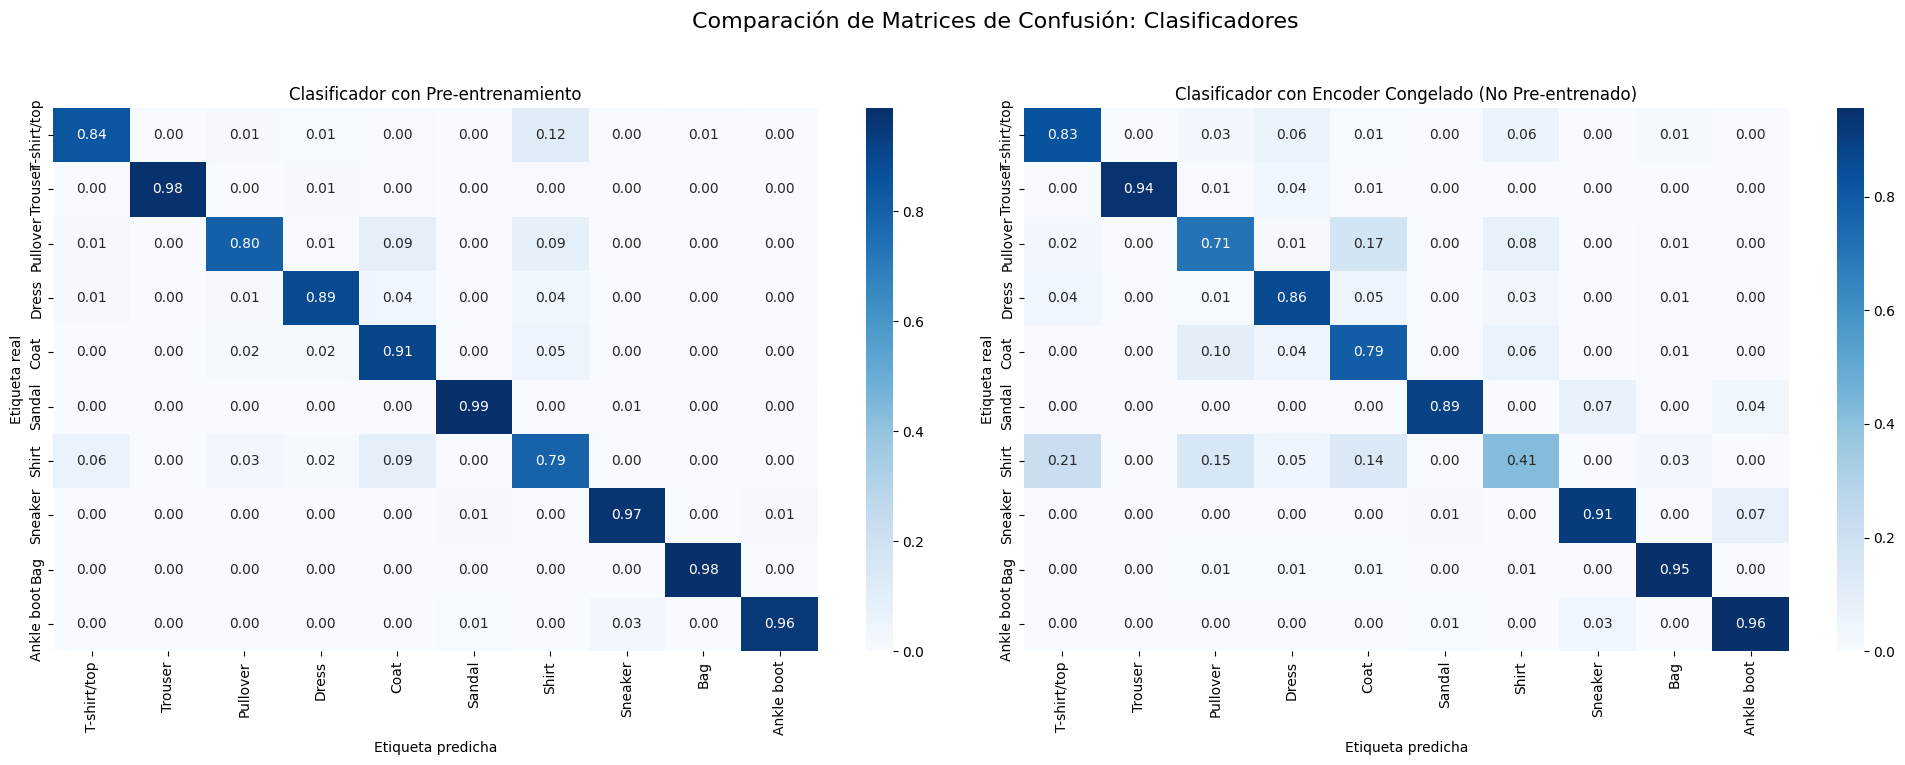

Figura guardada en: /content/drive/MyDrive/Redes_Neuronales/figuras/Comparacion_Clasificadores/comparacion_matrices_confusion_20251230_145729.png


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10}) # Adjust font size for better fit in subplots

clases = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # Create a figure with two subplots

# Plot Matriz_confusion_pre_entrenado
sns.heatmap(cm_valid_1, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=clases, yticklabels=clases, ax=axes[0])
axes[0].set_xlabel("Etiqueta predicha")
axes[0].set_ylabel("Etiqueta real")
axes[0].set_title("Clasificador con Pre-entrenamiento")

# Plot Matriz_confusion_noentrenado_congelado
sns.heatmap(cm_valid_2, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=clases, yticklabels=clases, ax=axes[1])
axes[1].set_xlabel("Etiqueta predicha")
axes[1].set_ylabel("Etiqueta real")
axes[1].set_title("Clasificador con Encoder Congelado (No Pre-entrenado)")

plt.suptitle("Comparación de Matrices de Confusión: Clasificadores", fontsize=16) # Main title
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
plt.show()

# Save the combined figure
guardar_figura(fig, "comparacion_matrices_confusion", "Comparacion_Clasificadores")

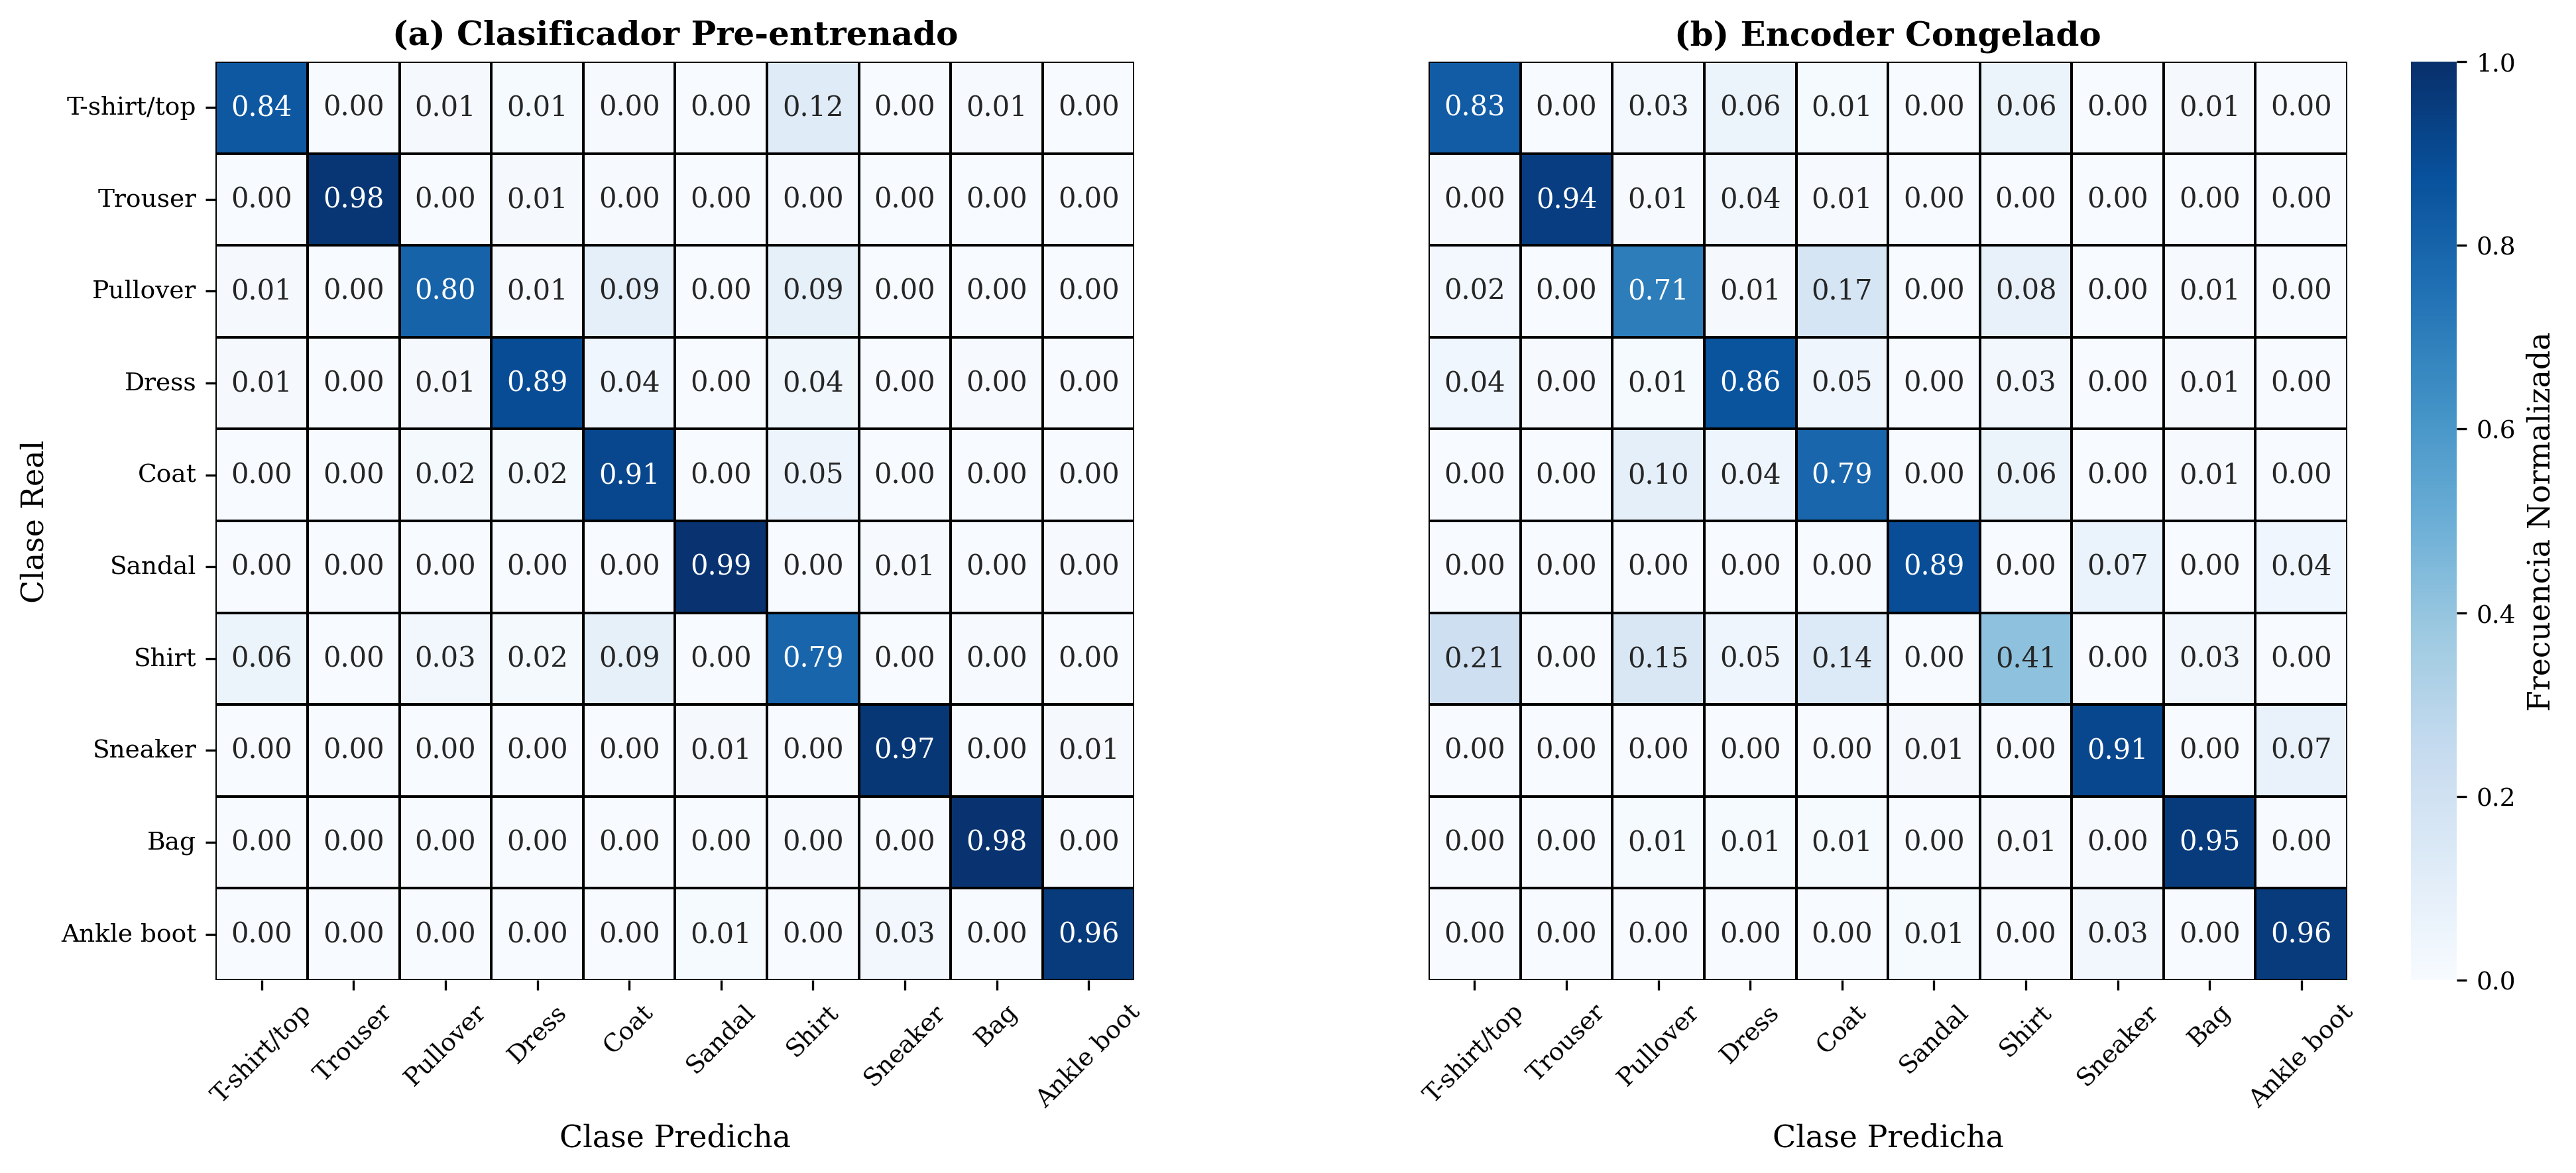

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuración global para estilo de paper ---
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',  # 'serif' (como Times New Roman) es más formal para papers
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9
})

clases = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# --- 1. Definición de la Figura ---
# figsize=(14, 6): Un formato más ancho para que las celdas no se aplasten.
# dpi=300: Resolución de impresión.
# sharey=True: Vincula los ejes Y. Si haces zoom en uno, el otro responde,
# y lo más importante: oculta las etiquetas del segundo eje Y automáticamente.
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300, sharey=True)

# Escala absoluta común. Asumo matrices normalizadas (0 a 1).
# Si tus matrices son conteos absolutos, cambia vmax al total de muestras por clase.
common_vmin, common_vmax = 0.0, 1.0

# --- 2. Primer Plot: Pre-entrenado ---
sns.heatmap(
    cm_valid_1,
    annot=True,
    fmt=".2f",          # Dos decimales
    cmap="Blues",
    vmin=common_vmin,   # Anclamos el mínimo de color
    vmax=common_vmax,   # Anclamos el máximo de color
    cbar=False,         # APAGAMOS la barra de color aquí (redundante)
    xticklabels=clases,
    yticklabels=clases,
    ax=axes[0],
    linewidths=0.5,     # Líneas finas entre celdas para definición
    linecolor='black',
    square=True         # Fuerza a que las celdas sean cuadradas
)

axes[0].set_title("(a) Clasificador Pre-entrenado", fontweight='bold')
axes[0].set_xlabel("Clase Predicha")
axes[0].set_ylabel("Clase Real")
axes[0].tick_params(axis='x', rotation=45) # Rotación para leer mejor

# --- 3. Segundo Plot: Congelado ---
sns.heatmap(
    cm_valid_2,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    vmin=common_vmin,   # Misma escala que el plot (a)
    vmax=common_vmax,
    cbar=True,          # ENCENDEMOS la barra de color aquí (sirve para ambos)
    cbar_kws={'label': 'Frecuencia Normalizada'}, # Etiqueta de la barra
    xticklabels=clases,
    yticklabels=clases, # Seaborn requiere pasarlos, pero sharey los ocultará visualmente
    ax=axes[1],
    linewidths=0.5,
    linecolor='black',
    square=True
)

axes[1].set_title("(b) Encoder Congelado", fontweight='bold')
axes[1].set_xlabel("Clase Predicha")
axes[1].set_ylabel("")  # Eliminamos explícitamente el título del eje Y
axes[1].tick_params(axis='y', length=0) # Quitamos las "marcas" (ticks) del eje Y para limpieza
axes[1].tick_params(axis='x', rotation=45)

# --- 4. Ajuste Final y Guardado ---
# tight_layout ajusta los márgenes automáticamente para que nada se corte.
plt.tight_layout()

# Guardar con alta calidad
# bbox_inches='tight' recorta el espacio blanco sobrante alrededor de la figura
# plt.savefig("comparacion_matrices_paper.png", dpi=300, bbox_inches='tight')
# plt.savefig("comparacion_matrices_paper.pdf", bbox_inches='tight') # Mejor para papers (vectorial)

plt.show()

# Tu función original de guardado (asegúrate de que soporte dpi o usa el savefig de arriba)
# guardar_figura(fig, "comparacion_matrices_confusion", "Comparacion_Clasificadores")

## graficos finales

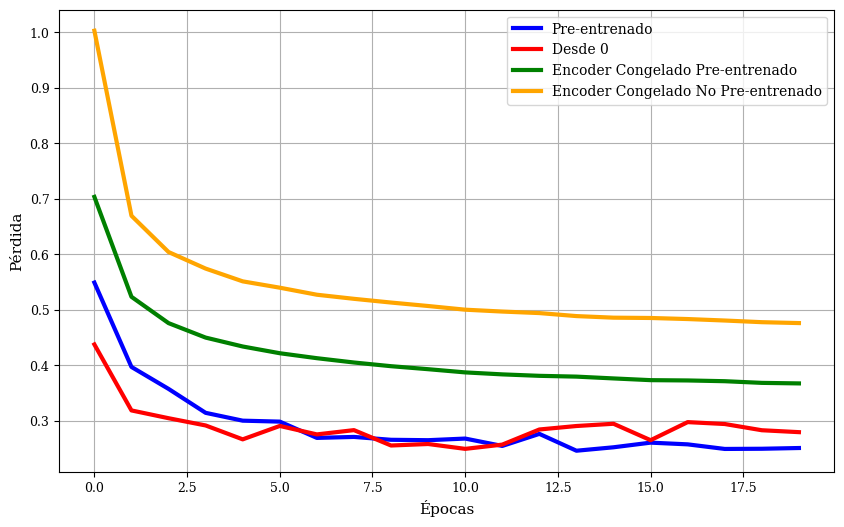

In [41]:
plt.figure(figsize=(10, 6), dpi=100) # Increased figure size for better visibility
plt.plot(Resultados[1]['valid_loss'], label="Pre-entrenado", color='blue')
plt.plot(Resultados[2]['valid_loss'], label="Desde 0", color='red')
plt.plot(Resultados[3]['valid_loss'], label="Encoder Congelado Pre-entrenado", color='green')
plt.plot(Resultados[4]['valid_loss'], label="Encoder Congelado No Pre-entrenado", color='orange')


plt.xlabel("Épocas")
plt.ylabel("Pérdida")
#valid loss
plt.legend()
plt.grid(True)
plt.show()

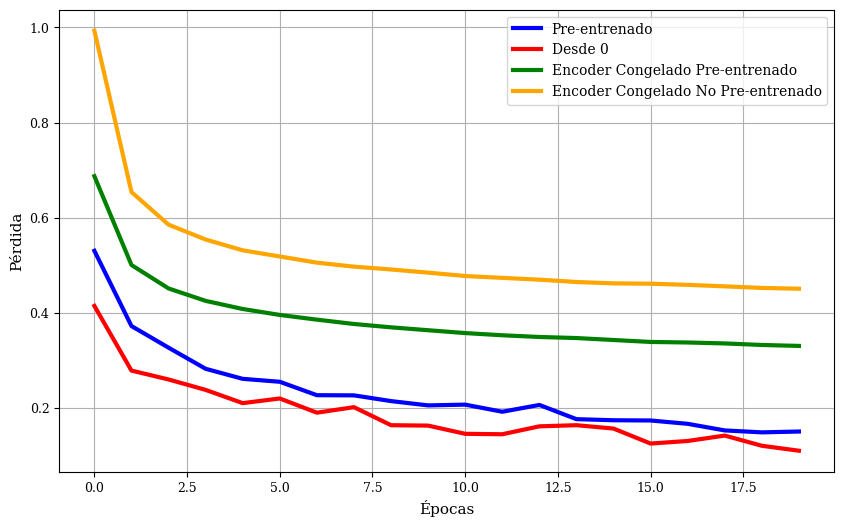

In [42]:
plt.figure(figsize=(10, 6), dpi=100) # Increased figure size for better visibility
plt.plot(Resultados[1]['train_loss'], label="Pre-entrenado", color='blue')
plt.plot(Resultados[2]['train_loss'], label="Desde 0", color='red')
plt.plot(Resultados[3]['train_loss'], label="Encoder Congelado Pre-entrenado", color='green')
plt.plot(Resultados[4]['train_loss'], label="Encoder Congelado No Pre-entrenado", color='orange')


plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()

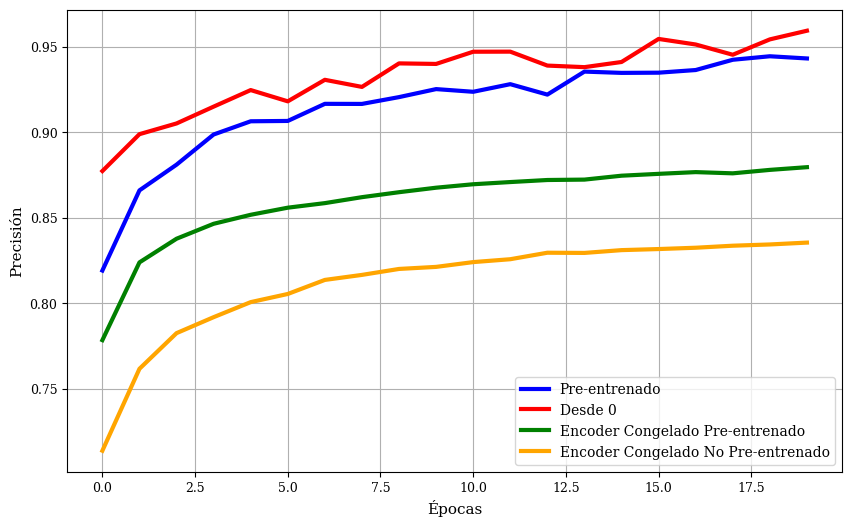

In [43]:
plt.figure(figsize=(10, 6), dpi=100) # Increased figure size for better visibility
plt.plot(Resultados[1]['train_acc'], label="Pre-entrenado", color='blue')
plt.plot(Resultados[2]['train_acc'], label="Desde 0", color='red')
plt.plot(Resultados[3]['train_acc'], label="Encoder Congelado Pre-entrenado", color='green')
plt.plot(Resultados[4]['train_acc'], label="Encoder Congelado No Pre-entrenado", color='orange')


plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.grid(True)
plt.show()

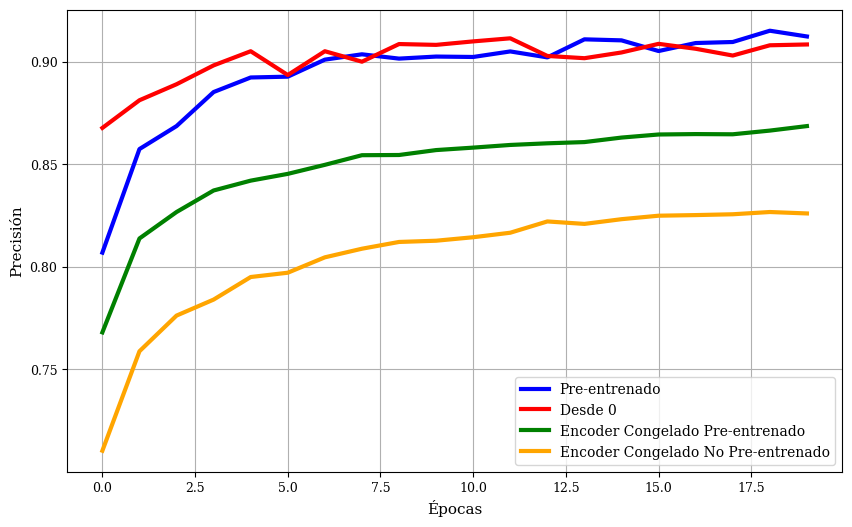

In [44]:
plt.figure(figsize=(10, 6), dpi=100) # Increased figure size for better visibility
plt.plot(Resultados[1]['valid_acc'], label="Pre-entrenado", color='blue')
plt.plot(Resultados[2]['valid_acc'], label="Desde 0", color='red')
plt.plot(Resultados[3]['valid_acc'], label="Encoder Congelado Pre-entrenado", color='green')
plt.plot(Resultados[4]['valid_acc'], label="Encoder Congelado No Pre-entrenado", color='orange')


plt.xlabel("Épocas")
plt.ylabel("Precisión")

plt.legend()
plt.grid(True)
plt.show()

Loading model for 1 epochs...
Successfully loaded and reconstructed for 1 epochs.
Loading model for 5 epochs...
Successfully loaded and reconstructed for 5 epochs.
Loading model for 10 epochs...
Successfully loaded and reconstructed for 10 epochs.


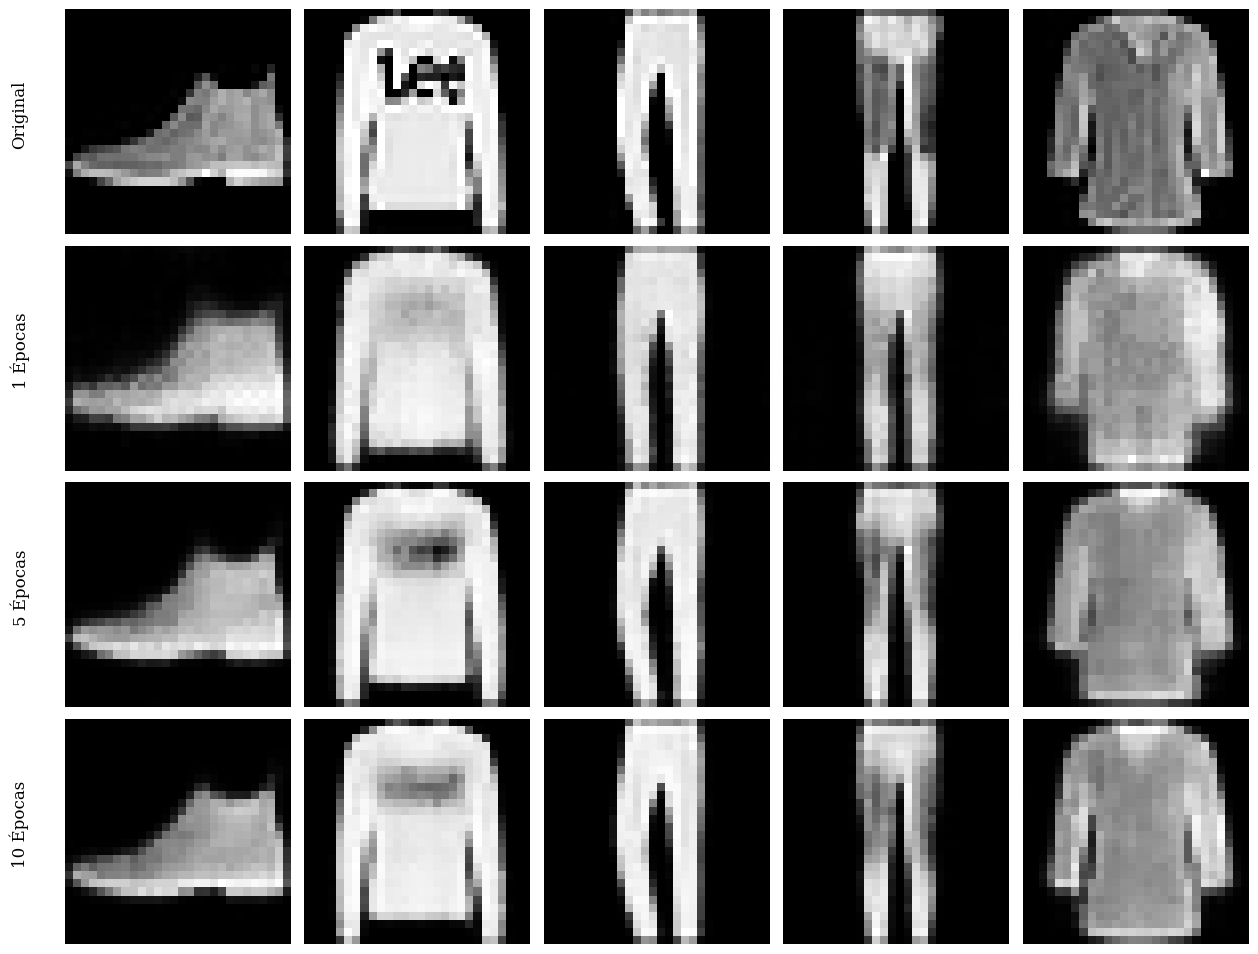

Figura guardada en: /content/drive/MyDrive/Redes_Neuronales/figuras/comparativa_reconstrucciones/comparacion_reconstrucciones_por_epocas_20251230_145741.png


In [45]:
p_dropout = 0.2
L_R = 0.001 # Keeping L_R consistent, though not used in plotting
epocas_list = [1, 5, 10]
checkpoint_interval = 1 # Not directly used in plotting, but good to keep if related to checkpoint names
num_images_to_show = 5 # Display more images for better comparison

# 1. Get a fixed batch of original images to use across all reconstructions
dataiter = iter(valid_loader)
images, _ = next(dataiter)
images = images[:num_images_to_show].to(device)

# Prepare a dictionary to store reconstructed images for each epoch count
reconstructions_by_epoch = {}

# 2. Loop through epoch counts, load the corresponding model, and get reconstructions
for num_epochs in epocas_list:
    print(f"Loading model for {num_epochs} epochs...")
    model_temp = Autoencoder(p_dropout=p_dropout).to(device)
    checkpoint_dir_epoch = os.path.join(base_path, "checkpoints", f"Epocas_{num_epochs}")
    checkpoint_path = os.path.join(checkpoint_dir_epoch, f"checkpoint_epoch_{num_epochs}.pth")

    # Check if checkpoint exists before loading
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model_temp.load_state_dict(checkpoint['model_state_dict'])
        model_temp.eval() # Set model to evaluation mode
        with torch.no_grad():
            # Get reconstructions for the fixed set of original images
            reconstructed_images = model_temp(images).cpu().detach().numpy()
        reconstructions_by_epoch[num_epochs] = reconstructed_images
        print(f"Successfully loaded and reconstructed for {num_epochs} epochs.")
    else:
        print(f"Warning: Checkpoint not found for {num_epochs} epochs at {checkpoint_path}. Skipping.")


# 3. Create the multi-row plot for comparison
num_rows = 1 + len(reconstructions_by_epoch) # 1 row for originals + rows for each epoch's reconstructions
fig, axes = plt.subplots(num_rows, num_images_to_show, figsize=(2.5 * num_images_to_show, 2.5 * num_rows))

# Plot original images in the first row
for i in range(num_images_to_show):
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        # Using set_title with loc='left' for better positioning of row labels
        axes[0, i].set_title('Original', loc='left', x=-0.2, y=0.5, rotation=90, ha='center', va='center')

# Plot reconstructions for each epoch count in subsequent rows
row_idx = 1
for num_epochs in sorted(reconstructions_by_epoch.keys()): # Sort keys to ensure consistent order
    for i in range(num_images_to_show):
        axes[row_idx, i].imshow(reconstructions_by_epoch[num_epochs][i].squeeze(), cmap='gray')
        axes[row_idx, i].axis('off')
        if i == 0:
            # Using set_title with loc='left' for better positioning of row labels
            axes[row_idx, i].set_title(f'{num_epochs} Épocas', loc='left', x=-0.2, y=0.5, rotation=90, ha='center', va='center')
    row_idx += 1

#plt.suptitle('Comparación de Reconstrucciones del Autoencoder por Épocas', y=1.02, fontsize=16) # Add a main title
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05, top=0.95) # Adjust spacing for better appearance
plt.show()

# 4. Save the plot to Google Drive
guardar_figura(fig, "comparacion_reconstrucciones_por_epocas", "comparativa_reconstrucciones")